In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import multiprocessing
import random
import numpy as np
import matplotlib.pyplot as plt


def get_data_loaders(batch_size, val_fraction=0.2):

    transform = transforms.ToTensor()

    num_workers = multiprocessing.cpu_count()

    # Get train, validation and test

    # Let's start with train and validation
    trainval_data = datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )

    # Split in train and validation
    # NOTE: we set the generator with a fixed random seed for reproducibility
    train_len = int(len(trainval_data) * (1 - val_fraction))
    val_len = len(trainval_data) - train_len
    print(f"Using {train_len} examples for training and {val_len} for validation")
    train_subset, val_subset = torch.utils.data.random_split(
        trainval_data, [train_len, val_len], generator=torch.Generator().manual_seed(42)
    )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_subset, shuffle=True, batch_size=batch_size, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=val_subset, shuffle=False, batch_size=batch_size, num_workers=num_workers
    )

    # Get test data
    test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, num_workers=num_workers
    )
    print(f"Using {len(test_data)} for testing")

    return {
        'train': train_loader,
        'valid': val_loader,
        'test': test_loader
    }


def seed_all(seed=42):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def anomaly_detection_display(df):

    df.sort_values(by='loss', ascending=False, inplace=True)

    fig, sub = plt.subplots()
    df['loss'].hist(bins=100)
    sub.set_yscale('log')
    sub.set_xlabel("Score (loss)")
    sub.set_ylabel("Counts per bin")
    fig.suptitle("Distribution of score (loss)")

    fig, subs = plt.subplots(2, 20, figsize=(20, 3))

    for img, sub in zip(df['image'].iloc[:20], subs[0].flatten()):
        sub.imshow(img[0, ...], cmap='gray')
        sub.axis("off")

    for rec, sub in zip(df['reconstructed'].iloc[:20], subs[1].flatten()):
        sub.imshow(rec[0, ...], cmap='gray')
        sub.axis("off")

    fig.suptitle("Most difficult to reconstruct")
    subs[0][0].axis("on")
    subs[0][0].set_xticks([])
    subs[0][0].set_yticks([])
    subs[0][0].set_ylabel("Input")

    subs[1][0].axis("on")
    subs[1][0].set_xticks([])
    subs[1][0].set_yticks([])
    _ = subs[1][0].set_ylabel("Reconst")

    fig, subs = plt.subplots(2, 20, figsize=(20, 3))

    sample = df.iloc[7000:].sample(20)

    for img, sub in zip(sample['image'], subs[0].flatten()):
        sub.imshow(img[0, ...], cmap='gray')
        sub.axis("off")

    for rec, sub in zip(sample['reconstructed'], subs[1].flatten()):
        sub.imshow(rec[0, ...], cmap='gray')
        sub.axis("off")

    fig.suptitle("Sample of in-distribution numbers")
    subs[0][0].axis("on")
    subs[0][0].set_xticks([])
    subs[0][0].set_yticks([])
    subs[0][0].set_ylabel("Input")

    subs[1][0].axis("on")
    subs[1][0].set_xticks([])
    subs[1][0].set_yticks([])
    _ = subs[1][0].set_ylabel("Reconst")


In [2]:
import torch
import numpy as np
from torchvision import datasets
from torch import nn
import torchvision.models
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
import pandas as pd

# Ensure repeatibility
seed_all(42)

In [3]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=1024)

100%|██████████| 9912422/9912422 [00:00<00:00, 99394466.15it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 117039317.70it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24670272.13it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8873092.11it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


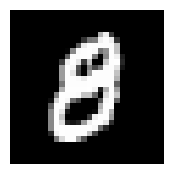

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize = (2,2))
sub.imshow(img, cmap='gray')
_ = sub.axis("off")

In [20]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        ## encoder ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 48, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(48)
        )

        ## decoder ##
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor = 2, mode='nearest'),
            nn.Conv2d(48, 60, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(60),
            nn.Upsample(scale_factor = 2, mode='nearest'),
            nn.Conv2d(60, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

        self.auto_encoder = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feedforward behavior
        # and scale the *output* layer with a sigmoid activation function

        return self.auto_encoder(x)

# initialize the NN
model = Autoencoder()

In [6]:
# specify loss function
criterion = nn.MSELoss()

In [22]:
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

In [24]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs + 1):
    # monitor training loss
    train_loss = 0.0

    if torch.cuda.is_available():
        model = model.cuda()

    model.train()

    ###################
    # train the model #
    ###################
    for data in tqdm(desc="Training", total=len(data_loaders['train']), iterable=data_loaders['train']):
        # we disregard the labels. We use the Python convention of calling
        # an unused variable "_"
        images, _ = data

        if torch.cuda.is_available():
            images = images.cuda()

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)

        # calculate the loss
        loss = criterion(outputs.flatten(), images.flatten())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * images.size(0)

    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid']):
            # _ stands in for labels, here
            images, _ = data

            if torch.cuda.is_available():
                images = images.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs.flatten(), images.flatten())

            # update running training loss
            val_loss += loss.item() * images.size(0)

    # print avg training statistics
    train_loss /= len(data_loaders['train'])
    val_loss /= len(data_loaders['valid'])
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|██████████| 12/12 [00:01<00:00,  8.60it/s]


Epoch: 1 	Training Loss: 2.232464	Valid Loss: 2.364083


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.68it/s]


Epoch: 2 	Training Loss: 2.154622	Valid Loss: 2.091267


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.14it/s]


Epoch: 3 	Training Loss: 2.181107	Valid Loss: 1.991038


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.57it/s]


Epoch: 4 	Training Loss: 2.118148	Valid Loss: 2.166116


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.55it/s]


Epoch: 5 	Training Loss: 2.083732	Valid Loss: 1.944516


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.64it/s]


Epoch: 6 	Training Loss: 2.095112	Valid Loss: 1.918845


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.64it/s]


Epoch: 7 	Training Loss: 1.975686	Valid Loss: 1.832157


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.57it/s]


Epoch: 8 	Training Loss: 1.911212	Valid Loss: 2.035903


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.66it/s]


Epoch: 9 	Training Loss: 1.941641	Valid Loss: 1.920055


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.54it/s]


Epoch: 10 	Training Loss: 1.853729	Valid Loss: 1.881484


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.71it/s]


Epoch: 11 	Training Loss: 1.841645	Valid Loss: 1.717809


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.57it/s]


Epoch: 12 	Training Loss: 1.808768	Valid Loss: 1.708198


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.56it/s]


Epoch: 13 	Training Loss: 1.828021	Valid Loss: 1.701525


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.53it/s]


Epoch: 14 	Training Loss: 1.765522	Valid Loss: 1.716683


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.90it/s]


Epoch: 15 	Training Loss: 1.798579	Valid Loss: 1.724477


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.16it/s]


Epoch: 16 	Training Loss: 1.723270	Valid Loss: 1.651362


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.61it/s]


Epoch: 17 	Training Loss: 1.673840	Valid Loss: 2.011545


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Epoch: 18 	Training Loss: 1.764812	Valid Loss: 1.580641


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.45it/s]


Epoch: 19 	Training Loss: 1.634551	Valid Loss: 1.595196


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.59it/s]

Epoch: 20 	Training Loss: 1.729886	Valid Loss: 1.814070


In [25]:
# Since this dataset is small we collect all the losses as well as
# the image and its reconstruction in a dictionary. In case of a
# larger dataset you might have to save on disk
# (won't fit in memory)
losses = {}

# We need the loss by example (not by batch)
loss_no_reduction = nn.MSELoss(reduction='none')

idx = 0

with torch.no_grad():
    for data in tqdm(desc="Testing", total=len(data_loaders['test']),
            iterable=data_loaders['test']
        ):

            images, labels = data

            if torch.cuda.is_available():
                images = images.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)

            # calculate the loss
            loss = loss_no_reduction(outputs, images)

            # Accumulate results per-example
            for i, l in enumerate(loss.mean(dim=[1, 2, 3])):
                losses[idx + i] = {
                    'loss': float(l.cpu().numpy()),
                    'image': images[i].cpu().numpy(),
                    'reconstructed': outputs[i].cpu().numpy()
                }

            idx += loss.shape[0]

# Let's save our results in a pandas DataFrame
df = pd.DataFrame(losses).T
df.head()

Testing: 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


,loss,image,reconstructed
0,0.001632,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0031746319, 0.0011663807, 0.0013136857, 0..."
1,0.002034,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0044008275, 0.0014096543, 0.0018498314, 0..."
2,0.000662,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0018861621, 0.0005390913, 0.00073377247, ..."
3,0.002201,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0029866842, 0.00076731393, 0.0007949019, ..."
4,0.00202,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0037199836, 0.0008962559, 0.00080422463, ..."


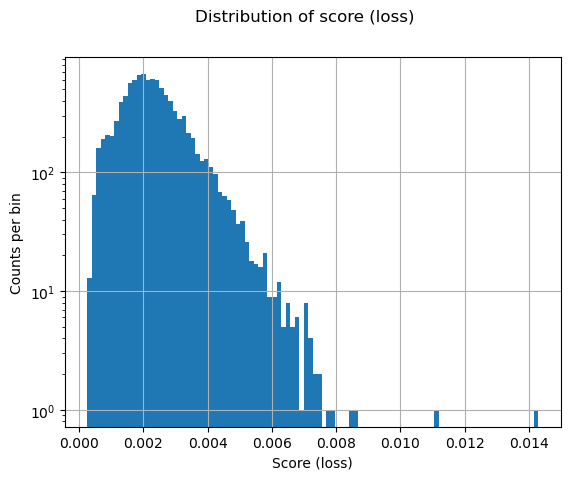

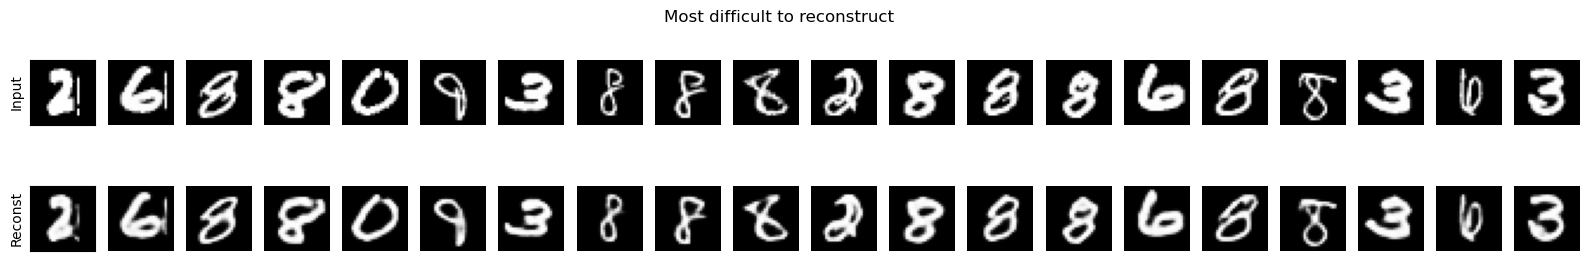

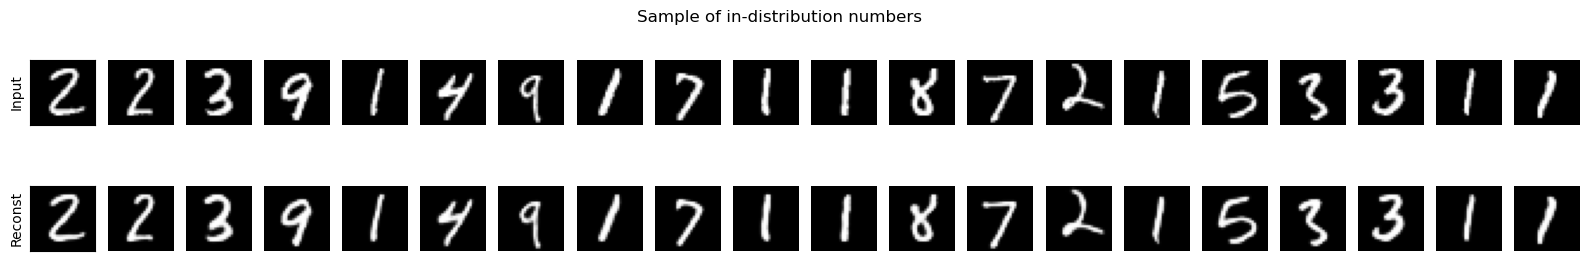

In [26]:
anomaly_detection_display(df)